<a href="https://colab.research.google.com/github/MSHQD/HWR/blob/main/model_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install hwb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.5 MB/s eta 0:00:00


# **Settings**

In [ ]:
!pip install transformers -q
!pip install -q datasets jiwer
!pip install sentencepiece -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.0 MB/s eta 0:00:00


In [ ]:
!ls -hl

total 24K
-rw-r--r--  1 root root  11K May 25 12:19 data_aug.py
drwx------  6 root root 4.0K May 25 12:18 drive
drwxr-xr-x  1 root root 4.0K May 14 13:38 sample_data
drwxr-xr-x 57 root root 4.0K May 25 12:19 unilm


In [ ]:
!git clone https://github.com/microsoft/unilm
!cp unilm/trocr/data_aug.py data_aug.py

Cloning into 'unilm'...
remote: Enumerating objects: 11087, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 11087 (delta 30), reused 18 (delta 18), pack-reused 11048 (from 2)
Receiving objects: 100% (11087/11087), 67.98 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (5289/5289), done.
Updating files: 100% (5993/5993), done.


In [ ]:
import cv2
import random
import json
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
from skimage import io
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.nn.utils.rnn import pad_sequence

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


In [ ]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
SEED = 42
def set_seed(seed: int = 42, set_torch=True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    if set_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(SEED)

# **Global variables**

In [ ]:
DATA_DIR = "/content/train_recognition_small"
TRAIN_DIR = "/content/train_recognition_small/images"
# TRAIN_DIR = '/content/data'
PROJECT_DIR = '/content/drive/MyDrive'
MODEL_DIR = os.path.join(PROJECT_DIR, 'segmentation_models')
TRAIN_BATCH_SIZE = 10
model_type = 'small'
VAL_BATCH_SIZE = 64
img_size = (384, 384) #(256, 256) #

# **Load datasets**

In [ ]:
import zipfile
zip1 = '/content/drive/MyDrive/train_recognition_small.zip'
extract_to1 = '/content/train_recognition_small'

with zipfile.ZipFile(zip1, 'r') as zip_ref:
    zip_ref.extractall(extract_to1)

In [ ]:
hack_data = pd.read_csv('train_recognition_small/train_recognition_small/labels_small.csv')
hack_data = hack_data.rename(columns={
    'file_name': 'image',
    'text': 'label'
})

In [ ]:
from pathlib import Path

hack_data['image'] = hack_data['image'].apply(lambda x: os.path.join('train_recognition_small/train_recognition_small/images', Path(x).name))

## see datasets intersection

In [ ]:
def dhash(image, hashSize=8):
	resized = cv2.resize(image, (hashSize + 1, hashSize))
	diff = resized[:, 1:] > resized[:, :-1]
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [ ]:
hack_hashes = [dhash(cv2.imread(path)) for path in tqdm(hack_data['image'])]


100%|██████████| 6000/6000 [00:07<00:00, 829.82it/s] 


In [ ]:
# second_stage_hashes = [dhash(cv2.imread(path)) for path in tqdm(second_stage_data['image'])]

In [ ]:
# len(set(second_stage_hashes) | set(hack_hashes)), len(set(second_stage_hashes) & set(hack_hashes))

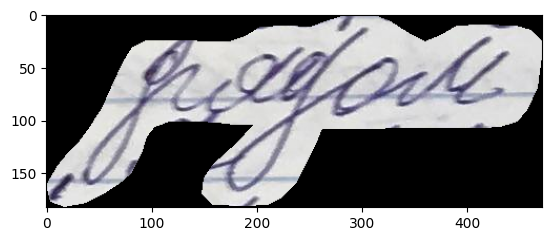

In [ ]:
s = 'рядом'
plt.imshow(plt.imread(hack_data[hack_data['label'] == s].iloc[0]['image']))

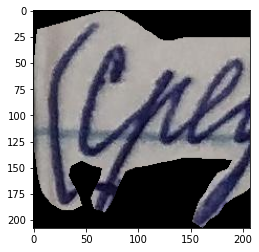

In [ ]:
# plt.imshow(plt.imread(second_stage_data[second_stage_data['label'] == s].iloc[0]['image']))

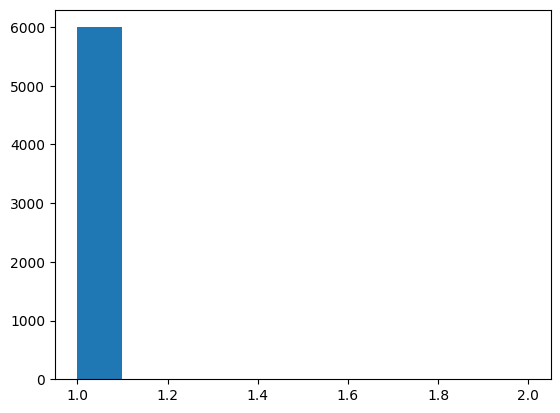

In [ ]:
plt.hist([len(el.split()) for el in hack_data['label']])
plt.show()

# **Building VAL dataset**

In [ ]:
# def get_one_words(df):
#   mask = [len(el.split()) == 1 or (len(el.split()) == 2 and (len(el[0]) < 3 or len(el[1] < 3))) for el in df['label']]
#   return df[np.array(mask)]

In [ ]:
# data = hack_data, get_one_words(hkr_data), get_one_words(our_data)], axis=0)

In [ ]:
hack_data.head()

,image,label
0,train_recognition_small/train_recognition_smal...,"дверку,"
1,train_recognition_small/train_recognition_smal...,открыл
2,train_recognition_small/train_recognition_smal...,Я
3,train_recognition_small/train_recognition_smal...,хвостом.
4,train_recognition_small/train_recognition_smal...,вилял


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(hack_data, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
df_val.shape

(1200, 2)

In [ ]:
df_val = df_val[['train_recognition_small' in el for el in df_val['image']]]

In [ ]:
df_val.shape

(1200, 2)

In [ ]:
def random_show(df):
  now = df.sample(1).iloc[0]
  img = plt.imread(now['image'])
  plt.imshow(img)
  plt.title(now['label'])
  plt.show()

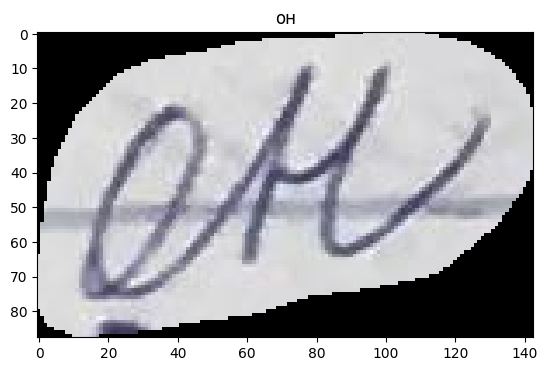

In [ ]:
random_show(hack_data)

In [ ]:
df_train.shape, df_val.shape

((4800, 2), (1200, 2))

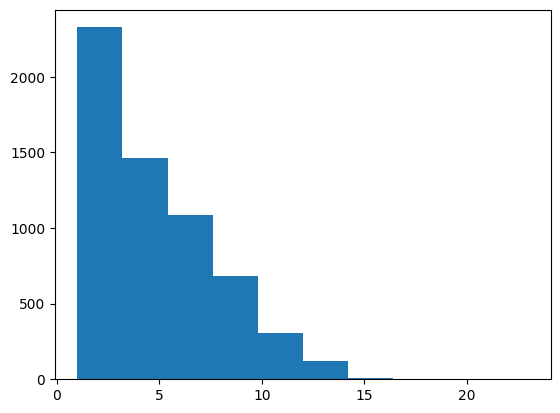

In [ ]:
plt.hist(hack_data['label'].apply(lambda x: len(x)))
plt.show()

# **Define dataset**

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, transforms, tokenizer, feature_extractor, max_target_length=64):
        self.root_dir = root_dir
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_target_length = max_target_length
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def _load_file(self, path):
      image = cv2.imread(path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return image

    def __getitem__(self, idx):
        el = self.df.iloc[idx]
        file_name = el['image']
        text = el['label']

        image = self._load_file(os.path.join(self.root_dir, file_name))
        image = self.transforms(image=image)['image']

        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(text,
                                padding="max_length",
                                max_length=self.max_target_length).input_ids

        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
# from augmixations import HandWrittenBlot
from hwb import HandWrittenBlot
import albumentations as A


class AlbuHandWrittenBlot(A.DualTransform):
    def __init__(self, hwb, always_apply=False, p=0.5):
        super(AlbuHandWrittenBlot, self).__init__(always_apply, p)
        self.hwb = hwb

    def apply(self, image, **params):
        return self.hwb(image)


class AlbuPadding(A.DualTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(AlbuPadding, self).__init__(always_apply, p)

    def apply(self, image, **params):
        zeros = np.zeros((128, 384, 3))
        image = np.concatenate([zeros, image, zeros], axis=0)
        return image.astype(np.uint8)

In [ ]:
rectangle_info = {
    'x': (None, None),
    'y': (150, 220),
    'h': (60, 100),
    'w': (50, 80),
}

blot_params = {
    'incline': (-10, 10),
    'intensivity': (0.5, 0.9),
    'transparency': (0.05, 0.4),
    'count': (1, 3),
}

blots = HandWrittenBlot(rectangle_info, blot_params)

In [ ]:
from albumentations.pytorch.transforms import ToTensorV2

data_transforms = {
    'train': A.Compose([
              A.Resize(128, 384),
              AlbuPadding(always_apply=True),
              AlbuHandWrittenBlot(blots, p=0.3),
              A.Rotate(limit=[-7, 7]),
              A.OneOf([
                A.ToGray(always_apply=True),
                A.CLAHE(always_apply=True, clip_limit=15),
              ], 0.3)
          ]),
    'val': A.Compose([
              A.Resize(128, 384),
              AlbuPadding(always_apply=True),
          ]),
}

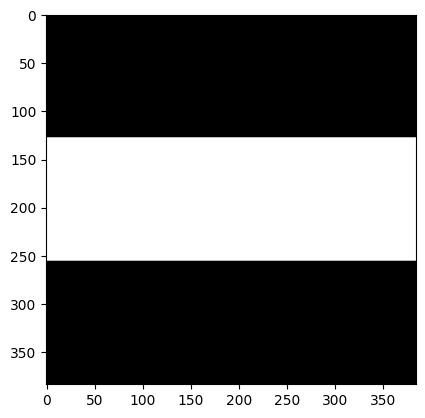

In [ ]:
plt.imshow(data_transforms['train'](image=np.ones((140, 312, 3)) * 255)['image'])

# **Define model**

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Загружаем модель и процессор
model = VisionEncoderDecoderModel.from_pretrained("raxtemur/trocr-base-ru")
processor = TrOCRProcessor.from_pretrained("raxtemur/trocr-base-ru")
# tokenizer = XLMRobertaTokenizer.from_pretrained('microsoft/trocr-small-handwritten')
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer
model.eval()

# model = VisionEncoderDecoderModel.from_pretrained(f'microsoft/trocr-small-handwritten')
# model = VisionEncoderDecoderModel.from_pretrained(f"/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_small_aug_nti2data")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [ ]:
def set_requires_grad(model, value) :
  for param in model.parameters():
    param.requires_grad = value

In [ ]:
model = model.to(device)

In [ ]:
model.decoder.resize_token_embeddings(len(tokenizer))

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id =  tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
# model.config.encoder.image_size = img_size
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
tokenizer.save_pretrained(os.path.join(PROJECT_DIR, 'ocr_models', f'trocr-{model_type}-handwritten-tokenizer'))
processor.save_pretrained(os.path.join(PROJECT_DIR, 'ocr_models', f'trocr-{model_type}-handwritten-feature-extractor'))

[]

# **Define loaders and try model**

In [ ]:
from transformers import TrOCRProcessor

train_dataset = IAMDataset(root_dir='./',
                           df=df_train,
                           transforms=data_transforms['train'],
                           tokenizer=tokenizer,
                           feature_extractor=processor)

val_dataset = IAMDataset(root_dir='./',
                         df=df_val,
                         transforms=data_transforms['val'],
                         tokenizer=tokenizer,
                         feature_extractor=processor)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 4800
Number of validation examples: 1200


In [ ]:
from torch.utils.data import DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16,)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16,)

In [ ]:
val_batch = next(iter(val_loader))
val_batch['pixel_values'].shape

torch.Size([8, 3, 384, 384])

In [ ]:
for k, v in val_batch.items():
  val_batch[k] = v.to(device)

In [ ]:
# %%time
y = model(**val_batch)

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

In [ ]:
def compute_cer(pred_ids, label_ids):
    pred_ids = pred_ids.cpu().numpy()
    label_ids = label_ids.cpu().numpy()

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return cer

# **Train model**

In [ ]:
def plot_images(images_for_show):
  """Строит изображение на одном графике"""
  fig = plt.figure(figsize=(16, 16))

  columns = len(images_for_show)
  rows = 1
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.clip(images_for_show[i - 1], 0, 1))

  fig.subplots_adjust(wspace=0.1, hspace=0)
  plt.show()

In [ ]:
def show_random_predict(model, test_loader, batch=None):
  """Выводит необходимую информацию после каждой эпохи"""
  if batch is None:
    batch = next(iter(test_loader))


  outputs = model.generate(batch["pixel_values"].to(device))
  now = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
  plot_images(torch.moveaxis(batch['pixel_values'][:4], 1, -1).detach().cpu().numpy())
  print([tokenizer.decode(pred.cpu().numpy(), skip_special_tokens=True) for pred in outputs[:4]])
  print([tokenizer.decode(el.cpu().numpy(), skip_special_tokens=True) for el in batch['labels'][:4]])

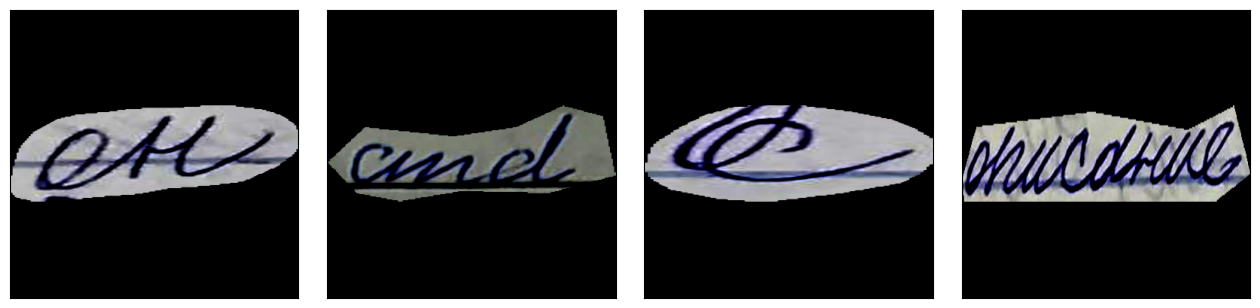

['он.', 'стол', 'Б', 'описание']
['он', 'and', 'с', 'описание']


In [ ]:
show_random_predict(model.train(True), val_loader)

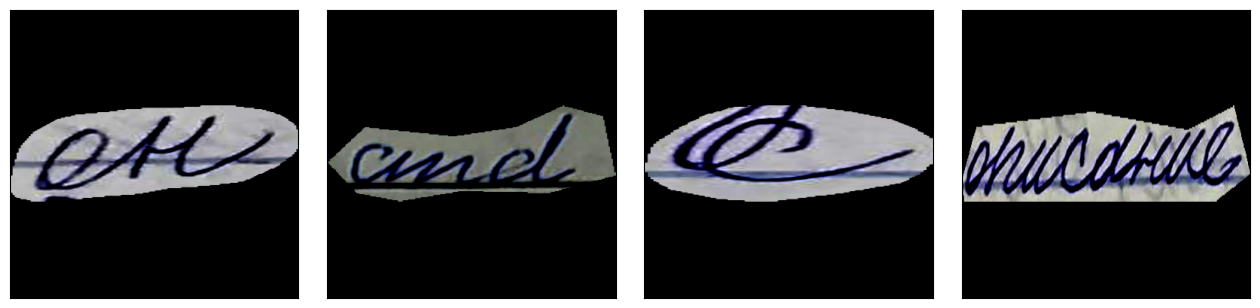

['он.', 'стол', 'Б', 'описание']
['он', 'and', 'с', 'описание']


In [ ]:
show_random_predict(model.train(False), val_loader)

In [ ]:
val_batch = next(iter(val_loader))
train_batch = next(iter(train_loader))

In [ ]:
import time

def train_epoch(model, batch_gen, criterion, optimizer, is_train = True, full_cer = False) :
    epoch_loss = 0.0
    count = 0
    cer = 0.0
    cnt_batches = 0
    # model.train(True)
    model.train(is_train)

    for batch in tqdm(batch_gen) :
        start = time.time()
        cnt_batches += 1

        for k, v in batch.items():
            batch[k] = v.to(device)

        with torch.set_grad_enabled(is_train) :
            outputs = model(**batch)
            loss = outputs.loss

            if is_train :
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            count += 1
            epoch_loss += loss.item()

            if cnt_batches % 1000 == 0 and is_train:
                # model.decoder.save_pretrained(f"/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_last_{model_type}_decoder")
                # model.encoder.save_pretrained(f"/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_last_{model_type}_encoder")
                model.save_pretrained(f"/content/drive/MyDrive/ocr_models/tr_ocr_last_{model_type}")

                outputs = model.generate(val_batch["pixel_values"].to(device))
                now = compute_cer(pred_ids=outputs, label_ids=val_batch["labels"])
                s = 'val batch cer = ' + str(now) + ' '

                outputs = model.generate(train_batch["pixel_values"].to(device))
                now = compute_cer(pred_ids=outputs, label_ids=train_batch["labels"])
                print(s + 'train batch cer = ', now)


            if not is_train and full_cer:
              outputs = model.generate(batch["pixel_values"])
              now = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
              cer += now

    if full_cer:
      now = cer / count
    else:
      outputs = model.generate(val_batch["pixel_values"].to(device))
      now = compute_cer(pred_ids=outputs, label_ids=val_batch["labels"])

    return epoch_loss / count, now


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, verbose=True):
    loader = {'train': train_loader, 'test': test_loader}
    loss_history = {'train': [], 'test': []}
    cer_history = {'train': [], 'test': []}
    best_loss = 0.12595586647062199 # 0.6189

    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        for phase in ['train', 'test']:
            epoch_loss, epoch_cer = train_epoch(model, loader[phase], criterion, optimizer, phase == 'train', full_cer=True)
            if verbose:
                print('{} Loss: {:.4f} Cer: {:.4f}'.format(phase, epoch_loss, epoch_cer))
            loss_history[phase].append(epoch_loss)
            cer_history[phase].append(epoch_cer)

        if scheduler is not None:
            scheduler.step()

        if verbose:
            show_random_predict(model, test_loader, val_batch)
            print()

        if loss_history['test'][-1] < best_loss:
          best_loss = loss_history['test'][-1]
          print('updated best loss on {} epoch, now it {}'.format(epoch, best_loss))
          # model.decoder.save_pretrained(f"/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_{model_type}_decoder")
          # model.encoder.save_pretrained(f"/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_{model_type}_encoder")
          model.save_pretrained(f"/content/drive/MyDrive/ocr_models/tr_ocr_best_{model_type}")

    return loss_history, cer_history

In [ ]:
epoch_loss, epoch_f1 = train_epoch(model, val_loader, None, None, False, True) # training on big dataset
epoch_loss, epoch_f1

  9%|▊         | 13/150 [1:28:02<16:48:28, 441.67s/it]

In [ ]:
epoch_loss, epoch_f1 = train_epoch(model, val_loader, None, None, False, True) # training on small dataset
epoch_loss, epoch_f1

100%|██████████| 1843/1843 [17:35<00:00,  1.75it/s]


(0.1520814513073257, 0.04998464634048)

In [ ]:
from torch.optim import lr_scheduler
optimizer = optim.Adam(model.parameters(), lr=5e-5)
lr_scheduler = None

Epoch 0/9
----------


  3%|▎         | 1000/36305 [04:19<24:49:38,  2.53s/it]

val batch cer = 0.9393939393939394 train batch cer =  0.9818181818181818


  6%|▌         | 2000/36305 [08:25<7:17:06,  1.31it/s]

val batch cer = 0.9393939393939394 train batch cer =  0.9090909090909091


  8%|▊         | 3000/36305 [12:31<6:50:26,  1.35it/s]

val batch cer = 0.9393939393939394 train batch cer =  0.9818181818181818


 11%|█         | 4000/36305 [16:36<6:48:42,  1.32it/s]

val batch cer = 1.0 train batch cer =  0.8909090909090909


 14%|█▍        | 5000/36305 [20:42<6:30:57,  1.33it/s]

val batch cer = 0.7878787878787878 train batch cer =  0.8181818181818182


 17%|█▋        | 6000/36305 [24:48<6:37:42,  1.27it/s]

val batch cer = 0.9393939393939394 train batch cer =  0.7454545454545455


 19%|█▉        | 7000/36305 [28:56<6:01:23,  1.35it/s]

val batch cer = 0.8787878787878788 train batch cer =  0.7090909090909091


 22%|██▏       | 8000/36305 [33:02<6:02:50,  1.30it/s]

val batch cer = 0.6666666666666666 train batch cer =  0.7636363636363637


 25%|██▍       | 9000/36305 [37:08<5:44:48,  1.32it/s]

val batch cer = 0.5454545454545454 train batch cer =  0.6545454545454545


 28%|██▊       | 10000/36305 [41:14<5:33:00,  1.32it/s]

val batch cer = 0.5151515151515151 train batch cer =  0.509090909090909


 30%|███       | 11000/36305 [45:20<5:10:45,  1.36it/s]

val batch cer = 0.45454545454545453 train batch cer =  0.43636363636363634


 33%|███▎      | 12000/36305 [49:26<5:07:24,  1.32it/s]

val batch cer = 0.45454545454545453 train batch cer =  0.43636363636363634


 36%|███▌      | 13000/36305 [53:34<5:06:22,  1.27it/s]

val batch cer = 0.30303030303030304 train batch cer =  0.36363636363636365


 39%|███▊      | 14000/36305 [57:41<4:42:38,  1.32it/s]

val batch cer = 0.21212121212121213 train batch cer =  0.2545454545454545


 41%|████▏     | 15000/36305 [1:01:49<4:27:38,  1.33it/s]

val batch cer = 0.36363636363636365 train batch cer =  0.2545454545454545


 44%|████▍     | 16000/36305 [1:05:56<4:31:27,  1.25it/s]

val batch cer = 0.24242424242424243 train batch cer =  0.2


 47%|████▋     | 17000/36305 [1:10:03<4:01:35,  1.33it/s]

val batch cer = 0.30303030303030304 train batch cer =  0.2545454545454545


 50%|████▉     | 18000/36305 [1:14:10<3:51:24,  1.32it/s]

val batch cer = 0.30303030303030304 train batch cer =  0.18181818181818182


 52%|█████▏    | 19000/36305 [1:18:18<3:35:43,  1.34it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.16363636363636364


 55%|█████▌    | 20000/36305 [1:22:26<3:25:20,  1.32it/s]

val batch cer = 0.2727272727272727 train batch cer =  0.12727272727272726


 58%|█████▊    | 21000/36305 [1:26:33<3:10:05,  1.34it/s]

val batch cer = 0.21212121212121213 train batch cer =  0.2


 61%|██████    | 22000/36305 [1:30:41<2:56:54,  1.35it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.2


 63%|██████▎   | 23000/36305 [1:34:48<2:48:55,  1.31it/s]

val batch cer = 0.24242424242424243 train batch cer =  0.10909090909090909


 66%|██████▌   | 24000/36305 [1:38:54<2:35:52,  1.32it/s]

val batch cer = 0.24242424242424243 train batch cer =  0.16363636363636364


 69%|██████▉   | 25000/36305 [1:43:00<2:24:36,  1.30it/s]

val batch cer = 0.24242424242424243 train batch cer =  0.07272727272727272


 72%|███████▏  | 26000/36305 [1:47:07<2:21:08,  1.22it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.07272727272727272


 74%|███████▍  | 27000/36305 [1:51:13<1:56:23,  1.33it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.09090909090909091


 77%|███████▋  | 28000/36305 [1:55:19<1:44:37,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.05454545454545454


 80%|███████▉  | 29000/36305 [1:59:25<1:32:44,  1.31it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.07272727272727272


 83%|████████▎ | 30000/36305 [2:03:31<1:19:45,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.09090909090909091


 85%|████████▌ | 31000/36305 [2:07:38<1:07:39,  1.31it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.10909090909090909


 88%|████████▊ | 32000/36305 [2:11:45<54:49,  1.31it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.05454545454545454


 91%|█████████ | 33000/36305 [2:15:51<42:19,  1.30it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 94%|█████████▎| 34000/36305 [2:19:58<30:48,  1.25it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.05454545454545454


 96%|█████████▋| 35000/36305 [2:24:04<16:24,  1.33it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.03636363636363636


 99%|█████████▉| 36000/36305 [2:28:11<03:56,  1.29it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


100%|██████████| 36305/36305 [2:29:26<00:00,  4.05it/s]


train Loss: 1.0728 Cer: 0.0000


100%|██████████| 4034/4034 [31:58<00:00,  2.10it/s]


test Loss: 0.3611 Cer: 0.1545


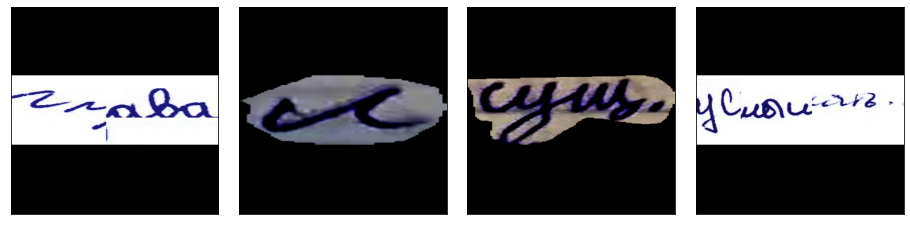

['глава', 'и', 'сущ.', 'услышать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 0 epoch, now it 0.3611266900502223
Epoch 1/9
----------


  3%|▎         | 1000/36305 [04:14<7:57:14,  1.23it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


  6%|▌         | 2000/36305 [08:20<7:20:38,  1.30it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.05454545454545454


  8%|▊         | 3000/36305 [12:27<7:00:53,  1.32it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 11%|█         | 4000/36305 [16:34<6:50:45,  1.31it/s]

val batch cer = 0.21212121212121213 train batch cer =  0.03636363636363636


 14%|█▍        | 5000/36305 [20:42<6:40:23,  1.30it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 17%|█▋        | 6000/36305 [24:49<6:24:53,  1.31it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 19%|█▉        | 7000/36305 [28:56<6:07:28,  1.33it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.07272727272727272


 22%|██▏       | 8000/36305 [33:02<6:00:13,  1.31it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 25%|██▍       | 9000/36305 [37:09<5:34:47,  1.36it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.05454545454545454


 28%|██▊       | 10000/36305 [41:16<5:39:59,  1.29it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.09090909090909091


 30%|███       | 11000/36305 [45:23<5:17:20,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 33%|███▎      | 12000/36305 [49:31<5:07:49,  1.32it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.07272727272727272


 36%|███▌      | 13000/36305 [53:38<5:15:37,  1.23it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 39%|███▊      | 14000/36305 [57:45<4:48:29,  1.29it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 41%|████▏     | 15000/36305 [1:01:53<4:37:12,  1.28it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.05454545454545454


 44%|████▍     | 16000/36305 [1:05:59<4:16:16,  1.32it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.10909090909090909


 47%|████▋     | 17000/36305 [1:10:06<3:57:59,  1.35it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 50%|████▉     | 18000/36305 [1:14:13<3:59:07,  1.28it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.05454545454545454


 52%|█████▏    | 19000/36305 [1:18:20<3:55:57,  1.22it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.05454545454545454


 55%|█████▌    | 20000/36305 [1:22:28<3:25:12,  1.32it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 58%|█████▊    | 21000/36305 [1:26:35<3:12:42,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.09090909090909091


 61%|██████    | 22000/36305 [1:30:42<3:00:42,  1.32it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.07272727272727272


 63%|██████▎   | 23000/36305 [1:34:49<2:54:58,  1.27it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 66%|██████▌   | 24000/36305 [1:38:56<2:31:39,  1.35it/s]

val batch cer = 0.18181818181818182 train batch cer =  0.05454545454545454


 69%|██████▉   | 25000/36305 [1:43:04<2:34:19,  1.22it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.05454545454545454


 72%|███████▏  | 26000/36305 [1:47:11<2:09:20,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.05454545454545454


 74%|███████▍  | 27000/36305 [1:51:19<1:55:02,  1.35it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.07272727272727272


 77%|███████▋  | 28000/36305 [1:55:26<1:42:52,  1.35it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.03636363636363636


 80%|███████▉  | 29000/36305 [1:59:33<1:30:53,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 83%|████████▎ | 30000/36305 [2:03:40<1:19:12,  1.33it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.05454545454545454


 85%|████████▌ | 31000/36305 [2:07:47<1:07:13,  1.32it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.05454545454545454


 88%|████████▊ | 32000/36305 [2:11:54<53:59,  1.33it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 91%|█████████ | 33000/36305 [2:16:01<40:44,  1.35it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 94%|█████████▎| 34000/36305 [2:20:09<29:18,  1.31it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 96%|█████████▋| 35000/36305 [2:24:16<16:28,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 99%|█████████▉| 36000/36305 [2:28:23<04:15,  1.19it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


100%|██████████| 36305/36305 [2:29:38<00:00,  4.04it/s]


train Loss: 0.3364 Cer: 0.0000


100%|██████████| 4034/4034 [30:59<00:00,  2.17it/s]


test Loss: 0.2266 Cer: 0.0941


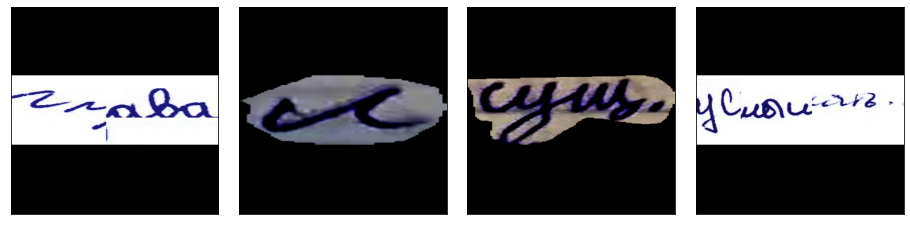

['глава', 'и', 'сущ.', 'услышать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 1 epoch, now it 0.2265857091621645
Epoch 2/9
----------


  3%|▎         | 1000/36305 [04:15<7:44:15,  1.27it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


  6%|▌         | 2000/36305 [08:23<7:58:27,  1.19it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


  8%|▊         | 3000/36305 [12:31<7:12:38,  1.28it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.05454545454545454


 11%|█         | 4000/36305 [16:39<6:42:52,  1.34it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 14%|█▍        | 5000/36305 [20:48<6:30:29,  1.34it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.03636363636363636


 17%|█▋        | 6000/36305 [24:56<6:26:31,  1.31it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 19%|█▉        | 7000/36305 [29:04<6:09:49,  1.32it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 22%|██▏       | 8000/36305 [33:12<6:21:46,  1.24it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 25%|██▍       | 9000/36305 [37:20<6:20:35,  1.20it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 28%|██▊       | 10000/36305 [41:28<5:33:55,  1.31it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.05454545454545454


 30%|███       | 11000/36305 [45:36<5:19:13,  1.32it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.09090909090909091


 33%|███▎      | 12000/36305 [49:44<5:08:11,  1.31it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.03636363636363636


 36%|███▌      | 13000/36305 [53:51<4:50:25,  1.34it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 39%|███▊      | 14000/36305 [57:59<4:36:03,  1.35it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 41%|████▏     | 15000/36305 [1:02:08<4:24:08,  1.34it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 44%|████▍     | 16000/36305 [1:06:16<4:22:02,  1.29it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 47%|████▋     | 17000/36305 [1:10:24<4:08:50,  1.29it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 50%|████▉     | 18000/36305 [1:14:32<3:51:15,  1.32it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 52%|█████▏    | 19000/36305 [1:18:39<4:00:43,  1.20it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 55%|█████▌    | 20000/36305 [1:22:48<3:29:00,  1.30it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.07272727272727272


 58%|█████▊    | 21000/36305 [1:26:56<3:07:09,  1.36it/s]

val batch cer = 0.18181818181818182 train batch cer =  0.03636363636363636


 61%|██████    | 22000/36305 [1:31:04<2:58:46,  1.33it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.05454545454545454


 63%|██████▎   | 23000/36305 [1:35:12<2:47:09,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 66%|██████▌   | 24000/36305 [1:39:21<2:33:36,  1.34it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 69%|██████▉   | 25000/36305 [1:43:30<2:21:53,  1.33it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 72%|███████▏  | 26000/36305 [1:47:40<2:09:11,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 74%|███████▍  | 27000/36305 [1:51:48<1:57:18,  1.32it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 77%|███████▋  | 28000/36305 [1:55:57<1:45:58,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 80%|███████▉  | 29000/36305 [2:00:05<1:33:12,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 83%|████████▎ | 30000/36305 [2:04:14<1:19:45,  1.32it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 85%|████████▌ | 31000/36305 [2:08:22<1:08:26,  1.29it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 88%|████████▊ | 32000/36305 [2:12:30<53:11,  1.35it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.05454545454545454


 91%|█████████ | 33000/36305 [2:16:39<43:12,  1.27it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.05454545454545454


 94%|█████████▎| 34000/36305 [2:20:48<29:03,  1.32it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.05454545454545454


 96%|█████████▋| 35000/36305 [2:24:56<16:21,  1.33it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 99%|█████████▉| 36000/36305 [2:29:06<03:53,  1.30it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


100%|██████████| 36305/36305 [2:30:22<00:00,  4.02it/s]


train Loss: 0.2405 Cer: 0.0000


100%|██████████| 4034/4034 [30:52<00:00,  2.18it/s]


test Loss: 0.1814 Cer: 0.0761


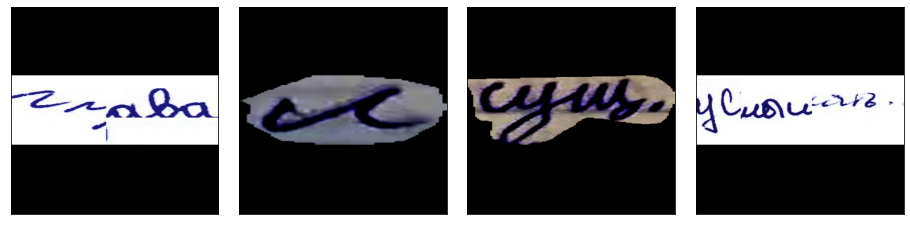

['глава', 'и', 'сущ.', 'уснылать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 2 epoch, now it 0.18144640238567988
Epoch 3/9
----------


  3%|▎         | 1000/36305 [04:15<7:47:14,  1.26it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


  6%|▌         | 2000/36305 [08:24<8:01:06,  1.19it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


  8%|▊         | 3000/36305 [12:33<7:05:56,  1.30it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 11%|█         | 4000/36305 [16:41<6:46:04,  1.33it/s]

val batch cer = 0.18181818181818182 train batch cer =  0.01818181818181818


 14%|█▍        | 5000/36305 [20:50<6:41:02,  1.30it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 17%|█▋        | 6000/36305 [24:59<6:29:37,  1.30it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 19%|█▉        | 7000/36305 [29:07<6:10:00,  1.32it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 22%|██▏       | 8000/36305 [33:16<6:40:48,  1.18it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 25%|██▍       | 9000/36305 [37:25<5:56:15,  1.28it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 28%|██▊       | 10000/36305 [41:34<5:32:30,  1.32it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 30%|███       | 11000/36305 [45:44<5:24:17,  1.30it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.03636363636363636


 33%|███▎      | 12000/36305 [49:54<5:28:32,  1.23it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.09090909090909091


 36%|███▌      | 13000/36305 [54:03<4:55:56,  1.31it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 39%|███▊      | 14000/36305 [58:12<4:37:25,  1.34it/s]

val batch cer = 0.21212121212121213 train batch cer =  0.03636363636363636


 41%|████▏     | 15000/36305 [1:02:21<4:32:16,  1.30it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.09090909090909091


 44%|████▍     | 16000/36305 [1:06:32<4:19:25,  1.30it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 47%|████▋     | 17000/36305 [1:10:41<4:06:00,  1.31it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.03636363636363636


 50%|████▉     | 18000/36305 [1:14:51<4:05:23,  1.24it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 52%|█████▏    | 19000/36305 [1:19:03<3:41:52,  1.30it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 55%|█████▌    | 20000/36305 [1:23:15<3:28:01,  1.31it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 58%|█████▊    | 21000/36305 [1:27:27<3:36:46,  1.18it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 61%|██████    | 22000/36305 [1:31:39<3:01:55,  1.31it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 63%|██████▎   | 23000/36305 [1:35:48<2:38:58,  1.39it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 66%|██████▌   | 24000/36305 [1:39:56<2:33:29,  1.34it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 69%|██████▉   | 25000/36305 [1:44:05<2:20:34,  1.34it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 72%|███████▏  | 26000/36305 [1:48:14<2:11:08,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 74%|███████▍  | 27000/36305 [1:52:24<1:56:57,  1.33it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 77%|███████▋  | 28000/36305 [1:56:32<1:43:19,  1.34it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 80%|███████▉  | 29000/36305 [2:00:41<1:31:58,  1.32it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 83%|████████▎ | 30000/36305 [2:04:50<1:17:20,  1.36it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 85%|████████▌ | 31000/36305 [2:08:59<1:05:41,  1.35it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 88%|████████▊ | 32000/36305 [2:13:08<53:50,  1.33it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.07272727272727272


 91%|█████████ | 33000/36305 [2:17:17<41:13,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 94%|█████████▎| 34000/36305 [2:21:25<29:44,  1.29it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 96%|█████████▋| 35000/36305 [2:25:34<16:22,  1.33it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.03636363636363636


 99%|█████████▉| 36000/36305 [2:29:43<03:52,  1.31it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


100%|██████████| 36305/36305 [2:30:59<00:00,  4.01it/s]


train Loss: 0.1927 Cer: 0.0000


100%|██████████| 4034/4034 [30:53<00:00,  2.18it/s]


test Loss: 0.1571 Cer: 0.0662


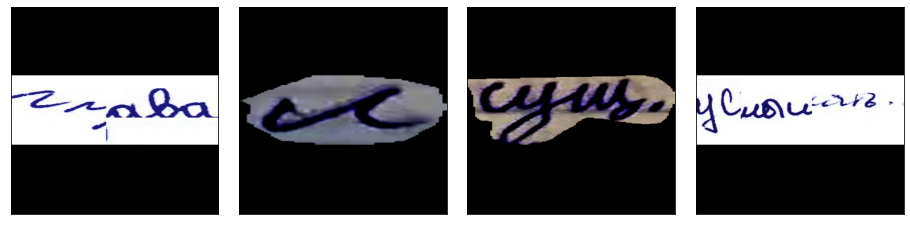

['глава', 'и', 'сущ.', 'уснышать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 3 epoch, now it 0.15711977596959595
Epoch 4/9
----------


  3%|▎         | 1000/36305 [04:15<7:42:08,  1.27it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


  6%|▌         | 2000/36305 [08:24<7:19:41,  1.30it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


  8%|▊         | 3000/36305 [12:34<6:56:50,  1.33it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.03636363636363636


 11%|█         | 4000/36305 [16:43<7:22:26,  1.22it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 14%|█▍        | 5000/36305 [20:53<6:23:02,  1.36it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 17%|█▋        | 6000/36305 [25:02<6:13:47,  1.35it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 19%|█▉        | 7000/36305 [29:12<6:47:58,  1.20it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 22%|██▏       | 8000/36305 [33:21<6:01:21,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 25%|██▍       | 9000/36305 [37:31<5:45:27,  1.32it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 28%|██▊       | 10000/36305 [41:41<5:28:40,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 30%|███       | 11000/36305 [45:50<5:13:31,  1.35it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 33%|███▎      | 12000/36305 [50:00<5:08:04,  1.31it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 36%|███▌      | 13000/36305 [54:10<4:54:59,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 39%|███▊      | 14000/36305 [58:19<4:42:39,  1.32it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 41%|████▏     | 15000/36305 [1:02:29<4:24:33,  1.34it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 44%|████▍     | 16000/36305 [1:06:38<4:15:25,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 47%|████▋     | 17000/36305 [1:10:47<4:04:33,  1.32it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 50%|████▉     | 18000/36305 [1:14:57<4:09:09,  1.22it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.09090909090909091


 52%|█████▏    | 19000/36305 [1:19:07<3:35:47,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 55%|█████▌    | 20000/36305 [1:23:17<3:22:31,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 58%|█████▊    | 21000/36305 [1:27:29<3:22:00,  1.26it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 61%|██████    | 22000/36305 [1:31:41<2:59:05,  1.33it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.05454545454545454


 63%|██████▎   | 23000/36305 [1:35:53<2:51:09,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 66%|██████▌   | 24000/36305 [1:40:05<2:33:49,  1.33it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 69%|██████▉   | 25000/36305 [1:44:16<2:23:01,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.05454545454545454


 72%|███████▏  | 26000/36305 [1:48:28<2:10:25,  1.32it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 74%|███████▍  | 27000/36305 [1:52:41<1:58:55,  1.30it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 77%|███████▋  | 28000/36305 [1:56:53<1:45:14,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 80%|███████▉  | 29000/36305 [2:01:06<1:32:14,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 83%|████████▎ | 30000/36305 [2:05:18<1:19:32,  1.32it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 85%|████████▌ | 31000/36305 [2:09:30<1:06:17,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 88%|████████▊ | 32000/36305 [2:13:41<55:03,  1.30it/s]

val batch cer = 0.15151515151515152 train batch cer =  0.01818181818181818


 91%|█████████ | 33000/36305 [2:17:53<42:23,  1.30it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 94%|█████████▎| 34000/36305 [2:22:05<29:47,  1.29it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 96%|█████████▋| 35000/36305 [2:26:16<16:22,  1.33it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.05454545454545454


 99%|█████████▉| 36000/36305 [2:30:27<03:54,  1.30it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


100%|██████████| 36305/36305 [2:31:43<00:00,  3.99it/s]


train Loss: 0.1618 Cer: 0.0000


100%|██████████| 4034/4034 [31:08<00:00,  2.16it/s]


test Loss: 0.1406 Cer: 0.0602


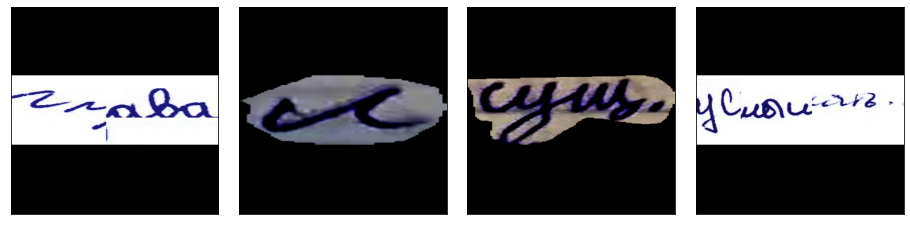

['глава', 'и', 'сущ.', 'услышать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 4 epoch, now it 0.1406191351247954
Epoch 5/9
----------


  3%|▎         | 1000/36305 [04:21<7:50:02,  1.25it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


  6%|▌         | 2000/36305 [08:35<7:38:23,  1.25it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


  8%|▊         | 3000/36305 [12:50<7:04:39,  1.31it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 11%|█         | 4000/36305 [17:03<6:54:49,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.05454545454545454


 14%|█▍        | 5000/36305 [21:15<7:23:23,  1.18it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 17%|█▋        | 6000/36305 [25:28<6:32:45,  1.29it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 19%|█▉        | 7000/36305 [29:41<6:17:04,  1.30it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 22%|██▏       | 8000/36305 [33:54<5:54:37,  1.33it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 25%|██▍       | 9000/36305 [38:06<5:48:48,  1.30it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 28%|██▊       | 10000/36305 [42:19<6:06:05,  1.20it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 30%|███       | 11000/36305 [46:32<5:19:42,  1.32it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 33%|███▎      | 12000/36305 [50:44<5:12:12,  1.30it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 36%|███▌      | 13000/36305 [54:54<4:50:26,  1.34it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 39%|███▊      | 14000/36305 [59:04<4:47:10,  1.29it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 41%|████▏     | 15000/36305 [1:03:14<4:22:38,  1.35it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 44%|████▍     | 16000/36305 [1:07:25<4:17:19,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 47%|████▋     | 17000/36305 [1:11:35<4:21:05,  1.23it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 50%|████▉     | 18000/36305 [1:15:46<3:57:40,  1.28it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 52%|█████▏    | 19000/36305 [1:19:55<3:35:57,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 55%|█████▌    | 20000/36305 [1:24:05<3:31:53,  1.28it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 58%|█████▊    | 21000/36305 [1:28:15<3:14:28,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 61%|██████    | 22000/36305 [1:32:25<2:55:59,  1.35it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.0


 63%|██████▎   | 23000/36305 [1:36:34<2:49:00,  1.31it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 66%|██████▌   | 24000/36305 [1:40:44<2:33:56,  1.33it/s]

val batch cer = 0.0 train batch cer =  0.0


 69%|██████▉   | 25000/36305 [1:44:55<2:24:41,  1.30it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 72%|███████▏  | 26000/36305 [1:49:04<2:12:13,  1.30it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.0


 74%|███████▍  | 27000/36305 [1:53:14<1:55:40,  1.34it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 77%|███████▋  | 28000/36305 [1:57:24<1:41:38,  1.36it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.01818181818181818


 80%|███████▉  | 29000/36305 [2:01:34<1:30:47,  1.34it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 83%|████████▎ | 30000/36305 [2:05:44<1:19:12,  1.33it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.05454545454545454


 85%|████████▌ | 31000/36305 [2:09:54<1:07:10,  1.32it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.0


 88%|████████▊ | 32000/36305 [2:14:04<54:32,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 91%|█████████ | 33000/36305 [2:18:13<41:19,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 94%|█████████▎| 34000/36305 [2:22:23<31:04,  1.24it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 96%|█████████▋| 35000/36305 [2:26:33<17:41,  1.23it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 99%|█████████▉| 36000/36305 [2:30:43<03:53,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


100%|██████████| 36305/36305 [2:31:59<00:00,  3.98it/s]


train Loss: 0.1403 Cer: 0.0000


100%|██████████| 4034/4034 [31:05<00:00,  2.16it/s]


test Loss: 0.1299 Cer: 0.0552


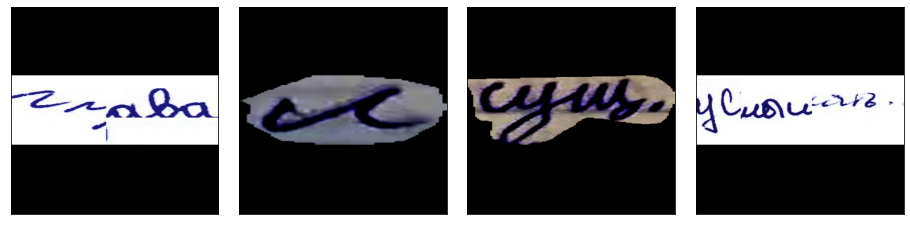

['глава', 'и', 'сущ.', 'усмышать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 5 epoch, now it 0.12991250184095712
Epoch 6/9
----------


  3%|▎         | 1000/36305 [04:21<7:47:58,  1.26it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.0


  6%|▌         | 2000/36305 [08:34<7:11:19,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


  8%|▊         | 3000/36305 [12:47<7:06:52,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 11%|█         | 4000/36305 [16:59<7:29:40,  1.20it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 14%|█▍        | 5000/36305 [21:10<6:29:13,  1.34it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 17%|█▋        | 6000/36305 [25:22<6:25:33,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 19%|█▉        | 7000/36305 [29:33<6:09:02,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 22%|██▏       | 8000/36305 [33:44<6:00:31,  1.31it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 25%|██▍       | 9000/36305 [37:55<5:45:40,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 28%|██▊       | 10000/36305 [42:06<5:30:05,  1.33it/s]

val batch cer = 0.0 train batch cer =  0.0


 30%|███       | 11000/36305 [46:18<5:19:35,  1.32it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 33%|███▎      | 12000/36305 [50:29<5:02:01,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 36%|███▌      | 13000/36305 [54:40<5:26:05,  1.19it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 39%|███▊      | 14000/36305 [58:51<4:37:28,  1.34it/s]

val batch cer = 0.0 train batch cer =  0.0


 41%|████▏     | 15000/36305 [1:03:01<4:25:05,  1.34it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 44%|████▍     | 16000/36305 [1:07:12<4:46:06,  1.18it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 47%|████▋     | 17000/36305 [1:11:23<4:01:42,  1.33it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 50%|████▉     | 18000/36305 [1:15:34<3:54:05,  1.30it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 52%|█████▏    | 19000/36305 [1:19:45<3:32:48,  1.36it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 55%|█████▌    | 20000/36305 [1:23:55<3:23:13,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 58%|█████▊    | 21000/36305 [1:28:05<3:10:16,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 61%|██████    | 22000/36305 [1:32:15<3:00:43,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 63%|██████▎   | 23000/36305 [1:36:26<2:43:57,  1.35it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 66%|██████▌   | 24000/36305 [1:40:37<2:39:18,  1.29it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.03636363636363636


 69%|██████▉   | 25000/36305 [1:44:47<2:23:33,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 72%|███████▏  | 26000/36305 [1:48:59<2:09:51,  1.32it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 74%|███████▍  | 27000/36305 [1:53:11<2:05:34,  1.23it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.05454545454545454


 77%|███████▋  | 28000/36305 [1:57:22<1:43:31,  1.34it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 80%|███████▉  | 29000/36305 [2:01:34<1:32:28,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.07272727272727272


 83%|████████▎ | 30000/36305 [2:05:46<1:18:35,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 85%|████████▌ | 31000/36305 [2:09:57<1:06:43,  1.33it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 88%|████████▊ | 32000/36305 [2:14:08<55:35,  1.29it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 91%|█████████ | 33000/36305 [2:18:19<41:03,  1.34it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


 94%|█████████▎| 34000/36305 [2:22:30<32:15,  1.19it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 96%|█████████▋| 35000/36305 [2:26:41<16:12,  1.34it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.03636363636363636


 99%|█████████▉| 36000/36305 [2:30:52<03:51,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


100%|██████████| 36305/36305 [2:32:08<00:00,  3.98it/s]


train Loss: 0.1239 Cer: 0.0000


100%|██████████| 4034/4034 [31:11<00:00,  2.16it/s]


test Loss: 0.1260 Cer: 0.0539


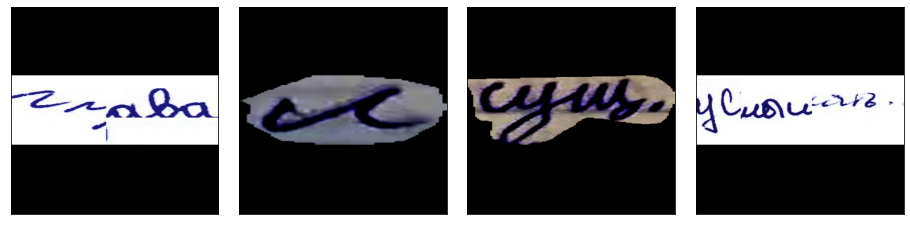

['глава', 'л', 'сущ.', 'услышать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 6 epoch, now it 0.12595586647062199
Epoch 7/9
----------


  3%|▎         | 1000/36305 [04:22<7:55:17,  1.24it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.01818181818181818


  6%|▌         | 2000/36305 [08:34<7:24:49,  1.29it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.0


  8%|▊         | 3000/36305 [12:47<7:10:59,  1.29it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 11%|█         | 4000/36305 [16:58<6:59:18,  1.28it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.0


 14%|█▍        | 5000/36305 [21:11<6:47:45,  1.28it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 17%|█▋        | 6000/36305 [25:25<6:47:46,  1.24it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 19%|█▉        | 7000/36305 [29:39<6:23:22,  1.27it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 22%|██▏       | 8000/36305 [33:54<6:18:35,  1.25it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 25%|██▍       | 9000/36305 [38:10<7:24:47,  1.02it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 28%|██▊       | 10000/36305 [42:26<5:44:13,  1.27it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 30%|███       | 11000/36305 [46:41<5:27:50,  1.29it/s]

val batch cer = 0.12121212121212122 train batch cer =  0.0


 33%|███▎      | 12000/36305 [50:57<5:12:06,  1.30it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 36%|███▌      | 13000/36305 [55:12<4:56:14,  1.31it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 39%|███▊      | 14000/36305 [59:28<4:49:22,  1.28it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.03636363636363636


 41%|████▏     | 15000/36305 [1:03:44<4:30:34,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 44%|████▍     | 16000/36305 [1:07:59<4:25:46,  1.27it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.03636363636363636


 47%|████▋     | 17000/36305 [1:12:14<4:06:18,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 50%|████▉     | 18000/36305 [1:16:30<3:59:14,  1.28it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 52%|█████▏    | 19000/36305 [1:20:45<3:44:11,  1.29it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 55%|█████▌    | 20000/36305 [1:25:02<3:34:29,  1.27it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.0


 58%|█████▊    | 21000/36305 [1:29:18<3:18:32,  1.28it/s]

val batch cer = 0.0 train batch cer =  0.0


 61%|██████    | 22000/36305 [1:33:32<3:01:41,  1.31it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 63%|██████▎   | 23000/36305 [1:37:46<2:51:07,  1.30it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.01818181818181818


 66%|██████▌   | 24000/36305 [1:42:01<2:35:15,  1.32it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 69%|██████▉   | 25000/36305 [1:46:14<2:36:02,  1.21it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 72%|███████▏  | 26000/36305 [1:50:29<2:10:30,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.0


 74%|███████▍  | 27000/36305 [1:54:43<2:00:46,  1.28it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 77%|███████▋  | 28000/36305 [1:58:57<1:44:29,  1.32it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 80%|███████▉  | 29000/36305 [2:03:11<1:30:47,  1.34it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.01818181818181818


 83%|████████▎ | 30000/36305 [2:07:25<1:19:46,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.01818181818181818


 84%|████████▍ | 30671/36305 [2:10:15<33:08,  2.83it/s]

In [ ]:
loss_history, cer_history = train_model(model, train_loader, val_loader, lr_scheduler, optimizer, None, 10)

Epoch 0/1
----------


  3%|▎         | 1000/36305 [04:20<8:24:46,  1.17it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


  6%|▌         | 2000/36305 [08:29<8:33:30,  1.11it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


  8%|▊         | 3000/36305 [12:35<7:01:13,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.0


 11%|█         | 4000/36305 [16:41<6:51:52,  1.31it/s]

val batch cer = 0.0 train batch cer =  0.0


 14%|█▍        | 5000/36305 [20:47<7:07:09,  1.22it/s]

val batch cer = 0.0 train batch cer =  0.0


 17%|█▋        | 6000/36305 [24:53<6:28:37,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.0


 19%|█▉        | 7000/36305 [28:59<6:44:58,  1.21it/s]

val batch cer = 0.0 train batch cer =  0.0


 22%|██▏       | 8000/36305 [33:05<6:04:31,  1.29it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 25%|██▍       | 9000/36305 [37:11<5:50:25,  1.30it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 28%|██▊       | 10000/36305 [41:16<5:40:49,  1.29it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 30%|███       | 11000/36305 [45:22<5:27:17,  1.29it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 33%|███▎      | 12000/36305 [49:28<5:12:20,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.02040816326530612


 36%|███▌      | 13000/36305 [53:33<5:03:40,  1.28it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.02040816326530612


 39%|███▊      | 14000/36305 [57:40<5:15:57,  1.18it/s]

val batch cer = 0.0 train batch cer =  0.0


 41%|████▏     | 15000/36305 [1:01:46<4:31:18,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 44%|████▍     | 16000/36305 [1:05:53<4:44:41,  1.19it/s]

val batch cer = 0.0 train batch cer =  0.0


 47%|████▋     | 17000/36305 [1:09:59<4:10:05,  1.29it/s]

val batch cer = 0.0 train batch cer =  0.0


 50%|████▉     | 18000/36305 [1:14:05<4:02:05,  1.26it/s]

val batch cer = 0.0 train batch cer =  0.0


 52%|█████▏    | 19000/36305 [1:18:11<3:42:52,  1.29it/s]

val batch cer = 0.0 train batch cer =  0.0


 55%|█████▌    | 20000/36305 [1:22:18<3:31:52,  1.28it/s]

val batch cer = 0.0 train batch cer =  0.0


 58%|█████▊    | 21000/36305 [1:26:25<3:41:40,  1.15it/s]

val batch cer = 0.0 train batch cer =  0.0


 61%|██████    | 22000/36305 [1:30:31<3:26:50,  1.15it/s]

val batch cer = 0.0 train batch cer =  0.0


 63%|██████▎   | 23000/36305 [1:34:37<2:52:35,  1.28it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 66%|██████▌   | 24000/36305 [1:38:44<2:38:07,  1.30it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 69%|██████▉   | 25000/36305 [1:42:50<2:25:09,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.0


 72%|███████▏  | 26000/36305 [1:46:57<2:17:47,  1.25it/s]

val batch cer = 0.0 train batch cer =  0.0


 74%|███████▍  | 27000/36305 [1:51:03<1:58:23,  1.31it/s]

val batch cer = 0.0 train batch cer =  0.0


 77%|███████▋  | 28000/36305 [1:55:09<1:47:11,  1.29it/s]

val batch cer = 0.0 train batch cer =  0.0


 80%|███████▉  | 29000/36305 [1:59:15<1:35:38,  1.27it/s]

val batch cer = 0.0 train batch cer =  0.02040816326530612


 83%|████████▎ | 30000/36305 [2:03:22<1:23:57,  1.25it/s]

val batch cer = 0.0 train batch cer =  0.0


 85%|████████▌ | 31000/36305 [2:07:28<1:08:26,  1.29it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.0


 88%|████████▊ | 32000/36305 [2:11:35<56:11,  1.28it/s]

val batch cer = 0.0 train batch cer =  0.0


 91%|█████████ | 33000/36305 [2:15:42<43:09,  1.28it/s]

val batch cer = 0.0 train batch cer =  0.0


 94%|█████████▎| 34000/36305 [2:19:49<30:40,  1.25it/s]

val batch cer = 0.0 train batch cer =  0.0


 96%|█████████▋| 35000/36305 [2:23:56<18:26,  1.18it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 99%|█████████▉| 36000/36305 [2:28:03<04:06,  1.24it/s]

val batch cer = 0.0 train batch cer =  0.0


100%|██████████| 36305/36305 [2:29:18<00:00,  4.05it/s]


train Loss: 0.0663 Cer: 0.0000


100%|██████████| 4034/4034 [31:05<00:00,  2.16it/s]


test Loss: 0.0913 Cer: 0.0375


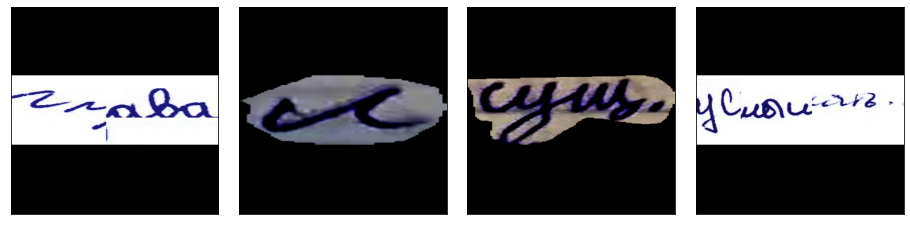

['Глава', 'и', 'сущ.', 'услышать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 0 epoch, now it 0.09131060182705135
Epoch 1/1
----------


  3%|▎         | 1000/36305 [04:14<8:00:46,  1.22it/s]

val batch cer = 0.09090909090909091 train batch cer =  0.0


  6%|▌         | 2000/36305 [08:23<7:17:38,  1.31it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


  8%|▊         | 3000/36305 [12:31<7:07:34,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.0


 11%|█         | 4000/36305 [16:39<6:53:41,  1.30it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 14%|█▍        | 5000/36305 [20:48<6:44:05,  1.29it/s]

val batch cer = 0.0 train batch cer =  0.0


 17%|█▋        | 6000/36305 [24:55<6:26:17,  1.31it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 19%|█▉        | 7000/36305 [29:04<6:10:22,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.0


 22%|██▏       | 8000/36305 [33:12<6:02:28,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.0


 25%|██▍       | 9000/36305 [37:20<5:36:39,  1.35it/s]

val batch cer = 0.0 train batch cer =  0.0


 28%|██▊       | 10000/36305 [41:27<5:24:32,  1.35it/s]

val batch cer = 0.0 train batch cer =  0.0


 30%|███       | 11000/36305 [45:33<5:08:16,  1.37it/s]

val batch cer = 0.0 train batch cer =  0.0


 33%|███▎      | 12000/36305 [49:40<5:10:45,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.0


 36%|███▌      | 13000/36305 [53:48<5:01:23,  1.29it/s]

val batch cer = 0.0 train batch cer =  0.0


 39%|███▊      | 14000/36305 [57:55<4:45:45,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.0


 41%|████▏     | 15000/36305 [1:02:02<4:52:43,  1.21it/s]

val batch cer = 0.0 train batch cer =  0.0


 44%|████▍     | 16000/36305 [1:06:10<4:12:50,  1.34it/s]

val batch cer = 0.0 train batch cer =  0.0


 47%|████▋     | 17000/36305 [1:10:18<4:08:13,  1.30it/s]

val batch cer = 0.0 train batch cer =  0.0


 50%|████▉     | 18000/36305 [1:14:25<3:51:21,  1.32it/s]

val batch cer = 0.0 train batch cer =  0.02040816326530612


 52%|█████▏    | 19000/36305 [1:18:33<3:49:50,  1.25it/s]

val batch cer = 0.0 train batch cer =  0.0


 55%|█████▌    | 20000/36305 [1:22:41<3:31:55,  1.28it/s]

val batch cer = 0.0 train batch cer =  0.0


 58%|█████▊    | 21000/36305 [1:26:50<3:18:36,  1.28it/s]

val batch cer = 0.0 train batch cer =  0.0


 61%|██████    | 22000/36305 [1:30:59<3:08:08,  1.27it/s]

val batch cer = 0.0 train batch cer =  0.0


 63%|██████▎   | 23000/36305 [1:35:08<2:53:05,  1.28it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 66%|██████▌   | 24000/36305 [1:39:17<2:39:18,  1.29it/s]

val batch cer = 0.0 train batch cer =  0.0


 69%|██████▉   | 25000/36305 [1:43:26<2:27:31,  1.28it/s]

val batch cer = 0.0 train batch cer =  0.0


 72%|███████▏  | 26000/36305 [1:47:35<2:13:00,  1.29it/s]

val batch cer = 0.0 train batch cer =  0.0


 74%|███████▍  | 27000/36305 [1:51:44<2:02:02,  1.27it/s]

val batch cer = 0.0 train batch cer =  0.0


 77%|███████▋  | 28000/36305 [1:55:55<1:59:29,  1.16it/s]

val batch cer = 0.0 train batch cer =  0.0


 80%|███████▉  | 29000/36305 [2:00:05<1:35:58,  1.27it/s]

val batch cer = 0.0 train batch cer =  0.0


 83%|████████▎ | 30000/36305 [2:04:15<1:22:34,  1.27it/s]

val batch cer = 0.030303030303030304 train batch cer =  0.0


 85%|████████▌ | 31000/36305 [2:08:26<1:10:04,  1.26it/s]

val batch cer = 0.06060606060606061 train batch cer =  0.0


 88%|████████▊ | 32000/36305 [2:12:37<57:01,  1.26it/s]

val batch cer = 0.0 train batch cer =  0.0


 91%|█████████ | 33000/36305 [2:16:48<44:07,  1.25it/s]

val batch cer = 0.0 train batch cer =  0.0


 94%|█████████▎| 34000/36305 [2:20:58<30:19,  1.27it/s]

val batch cer = 0.0 train batch cer =  0.0


 96%|█████████▋| 35000/36305 [2:25:08<18:50,  1.15it/s]

val batch cer = 0.0 train batch cer =  0.0


 99%|█████████▉| 36000/36305 [2:29:18<04:00,  1.27it/s]

val batch cer = 0.0 train batch cer =  0.0


100%|██████████| 36305/36305 [2:30:34<00:00,  4.02it/s]


train Loss: 0.0530 Cer: 0.0000


100%|██████████| 4034/4034 [31:31<00:00,  2.13it/s]


test Loss: 0.0892 Cer: 0.0367


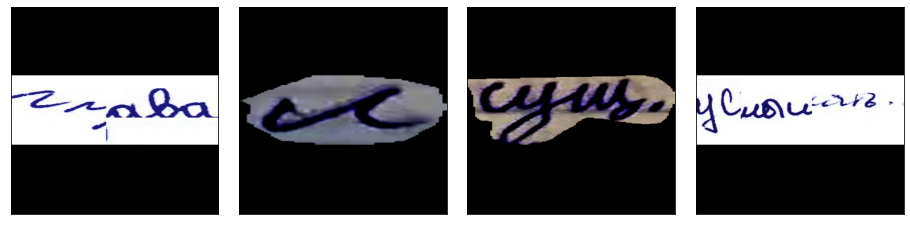

['Глава', 'и', 'сущ.', 'услышать.']
['Глава', 'и', 'сущ.', 'услышать.']

updated best loss on 1 epoch, now it 0.0891863788305084


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_history, cer_history = train_model(model, train_loader, val_loader, None, optimizer, None, 2)